# import libraries for the experiment

In [1]:
import sys
import os
import json
import random 

import numpy as np                                                                  
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt                                                       

import cv2
import mediapipe
import mediapipe as mp  

from glob import glob                                                               
from pathlib import Path                                                            
from natsort import natsorted 
import tqdm as t
from tqdm.auto import tqdm 

from sklearn.model_selection import train_test_split                                                
from collections import defaultdict
from typing import Callable, List, Tuple
from numpy.typing import NDArray

import torch
from torch import nn
import torch.optim as optim                                                          
import torch.nn.functional as F 
import seaborn as sns
from torch.utils.data import Dataset
from torch.utils.data import ConcatDataset
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter 
from torchinfo import summary

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
import captum

from captum.attr import Saliency
from captum.attr import IntegratedGradients
from captum.attr import LayerConductance

In [2]:
sys.path.append(os.path.abspath('../src'))
import prepare_datasets
import preprocess_utils 
import models  
import train_utils 
import plot_utils
import train
import analyse_layer

# Prepare Data

1. Extracting landmarks from the dataset using mediapipe and saving the results

In [5]:
# define paths (!Note: These paths are based on my computer setup and should be changed based on system file structure!)
# path to the dataset files
# root= 'C:/Users/sadeg/OneDrive/Desktop/Thesis/python_codes/datasets/lsa64_raw/all'

# path to where the landdmarks should be saved 
# save_dir= 'C:/Users/sadeg/OneDrive/Desktop/Thesis/python_codes/SignLanguageProject/data/landmarks_lsa64'


# 30frames
# result= prepare_datasets.get_landmarks(root, prepare_datasets.lsa64class_names, 30)     # get media pipe landmarks
# np.save(os.path.join(save_dir, 'detections30fps.npy'), np.array(result[0]))             # save media pipe landmarks
# with open(os.path.join(save_dir, 'labels30fps.json'), 'w') as file:                     # save labels
    # json.dump(result[1], file) 


# 40frames
# result= prepare_datasets.get_landmarks_LSA64(root, prepare_datasets.lsa64class_names, 40)   # get media pipe landmarks
# np.save(os.path.join(save_dir, 'detections40fps.npy'), np.array(result[0]))                 # save media pipe landmarks
# with open(os.path.join(save_dir, 'labels40fps.json'), 'w') as file:                         # save labels
    # json.dump(result[1], file) 


# 50frames
# result= prepare_datasets.get_landmarks_LSA64(root, prepare_datasets.lsa64class_names, 50)  # get media pipe landmarks
# np.save(os.path.join(save_dir, 'detections50fps.npy'), np.array(result[0]))                # save media pipe landmarks   
# with open(os.path.join(save_dir, 'labels50fps.json'), 'w') as file:                        # save labels
    # json.dump(result[1], file)


# 60frames
# result= prepare_datasets.get_landmarks_LSA64(root, prepare_datasets.lsa64class_names, 60)  # get media pipe landmarks
# np.save(os.path.join(save_dir, 'detections60fps.npy'), np.array(result[0]))                # save media pipe landmarks   
# with open(os.path.join(save_dir, 'labels60fps.json'), 'w') as file:                        # save labels
    # json.dump(result[1], file)

2. loading all saved landmarks and labels of LS-64 dataset

In [6]:
root_dir= os.path.dirname(os.getcwd())            # defining path to project folder
data_dir= os.path.join(root_dir, 'data')          # path to dataset directories
lsa= os.path.join(data_dir, 'landmarks_lsa64')    # path to LSA 64 detections directory

#dictionaries for accessing labels and detections easily based on frame number
lsa64_labels = {'30frames': None, '40frames': None, '50frames': None, '60frames': None} 
lsa64_detections = {'30frames': None, '40frames': None, '50frames': None, '60frames': None}

# loading detections and labels to the dictionaries
for frame_number in [30, 40, 50, 60]:
    lsa64_detections[f'{frame_number}frames']= np.load(os.path.join(lsa, f'detections{frame_number}fps.npy'), allow_pickle=True)
    with open(os.path.join(lsa, f'labels{frame_number}fps.json'), 'r') as file:
        lsa64_labels[f'{frame_number}frames']= json.load(file)

In [7]:
# Outputing the shape of the detections to make sure the extraction was successful
lsa64_detections['30frames'].shape, lsa64_detections['40frames'].shape, lsa64_detections['50frames'].shape, lsa64_detections['60frames'].shape

((3200, 30, 1662), (3200, 40, 1662), (3200, 50, 1662), (3200, 60, 1662))

In [8]:
# Outputing the number of labels to make sure every label has been extracted.
len(lsa64_labels['30frames']), len(lsa64_labels['40frames']), len(lsa64_labels['50frames']), len(lsa64_labels['60frames'])

(3200, 3200, 3200, 3200)

# Brief visualizing how augmentation process works

1. select 2 video samples

In [11]:
video_detection_1= lsa64_detections['30frames'][1500]                 # sample video 1
video_detection_2= lsa64_detections['30frames'][1501]                 # sample video 2
frame_structure= [(0, 132), (132, 1536), (1536, 1599), (1599, 1662)]  # start and end indexes of the body parts: pose, face, lh, rh

2. interpolate the video samples

In [12]:
# interpolate the videos
ivd = preprocess_utils.interpolate_video_detections(video_detection_1, video_detection_2, frame_structure, 0.5)

3. adding Gaussian noise

In [13]:
noise_level = 0.001  # Adjust as needed
constant_noise = np.random.normal(0, noise_level, ivd.shape[1:])
noisy_interpolated = np.clip(ivd + constant_noise, 0.001, 0.999)

4. visualizing the results

In [14]:
plot_utils.show_video_detections(video_detection_1)

In [15]:
plot_utils.show_video_detections(video_detection_2)

In [16]:
plot_utils.show_video_detections(ivd)

In [17]:
plot_utils.show_video_detections(noisy_interpolated)

# plotting average movements in the dataset

1. **Defining a dictionary** to store all videos belonging to the same label together.

The dictionary will have labels as keys and lists of videos as values. For example:

```python
{
    "Opaque": ["video1", "video2", "video3", ..., "video50"],
    "Red":  ["video1", "video2", "video3", ..., "video50"],
    "Green":   ["video13", "video2", "video3", ..., "video50"],
    ...
}

In [19]:
# a dictionary to store videos of same label
data= defaultdict(list)                         
for idx, label in enumerate(lsa64_labels['30frames']):
    data[label].append(lsa64_detections['30frames'][idx])

The `for` loop iterates through the dictionary, calculates the **mean movement** for each label and **plots** it as a single MHI image.

In [ ]:
for idx, item in enumerate(data.items()):             # idx is used to save the image at the end.
    mean_video= item[1][0]                            # select the first video sample of [video1, video2, video3, ..., video n]
    for video_detection in item[1]:
        # calculate mean using linear interpolation
        mean_video= preprocess_utils.interpolate_video_detections(video_detection_1= mean_video,
                                                                  video_detection_2= video_detection,
                                                                  frame_structure= [(0, 132), (132, 1536), (1536, 1599), (1599, 1662)],
                                                                  alpha= 0.5)
    # plot the average movement for each label and save it using idx variable
    plot_utils.plot_video_detection_as_MHI(video_detection= mean_video, 
                                           num_movements= 30,
                                           frame_structure= frame_structure,
                                           save_path= f'interpolated{idx+1}.png')

# Preparing the enviroment for training process

1. connecting device(Cuda)

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  #set up device to cuda
print(device)
print(torch.cuda.get_device_name())
print(torch.cuda.get_device_capability())

cuda
NVIDIA GeForce RTX 3060 Laptop GPU
(8, 6)


2. Eliminating face landmarks from the detection arrays

In [22]:
pose = np.arange(0, 132)                                                  # indexes of pose landmarks
lh_and_rh = np.arange(1536, 1662)                                         # indexes of left hand and right hand landmarks
indices_to_keep = np.concatenate((pose, lh_and_rh))                       # Concatenate indices to keep
filtered_detections = lsa64_detections['30frames'][:, :, indices_to_keep] # filter the data to remove face landmarks

In [23]:
# print shape to make sure it is correct
print(f"Shape of the original detections: {lsa64_detections['30frames'].shape}.\nShape of the filtered detections: {filtered_detections.shape}.")

Shape of the original detections: (3200, 30, 1662).
Shape of the filtered detections: (3200, 30, 258).


3. Initializing a transformer architecture

In [24]:
model= models.PETransformer(class_names= prepare_datasets.lsa64class_names,
                               seq_len= 30,
                               d_model= 258,
                               nhead= 6,
                               d_ff= 2048,
                               num_layers= 2,
                               dropout=0.1)

4. Training the model on the dataset

Training Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

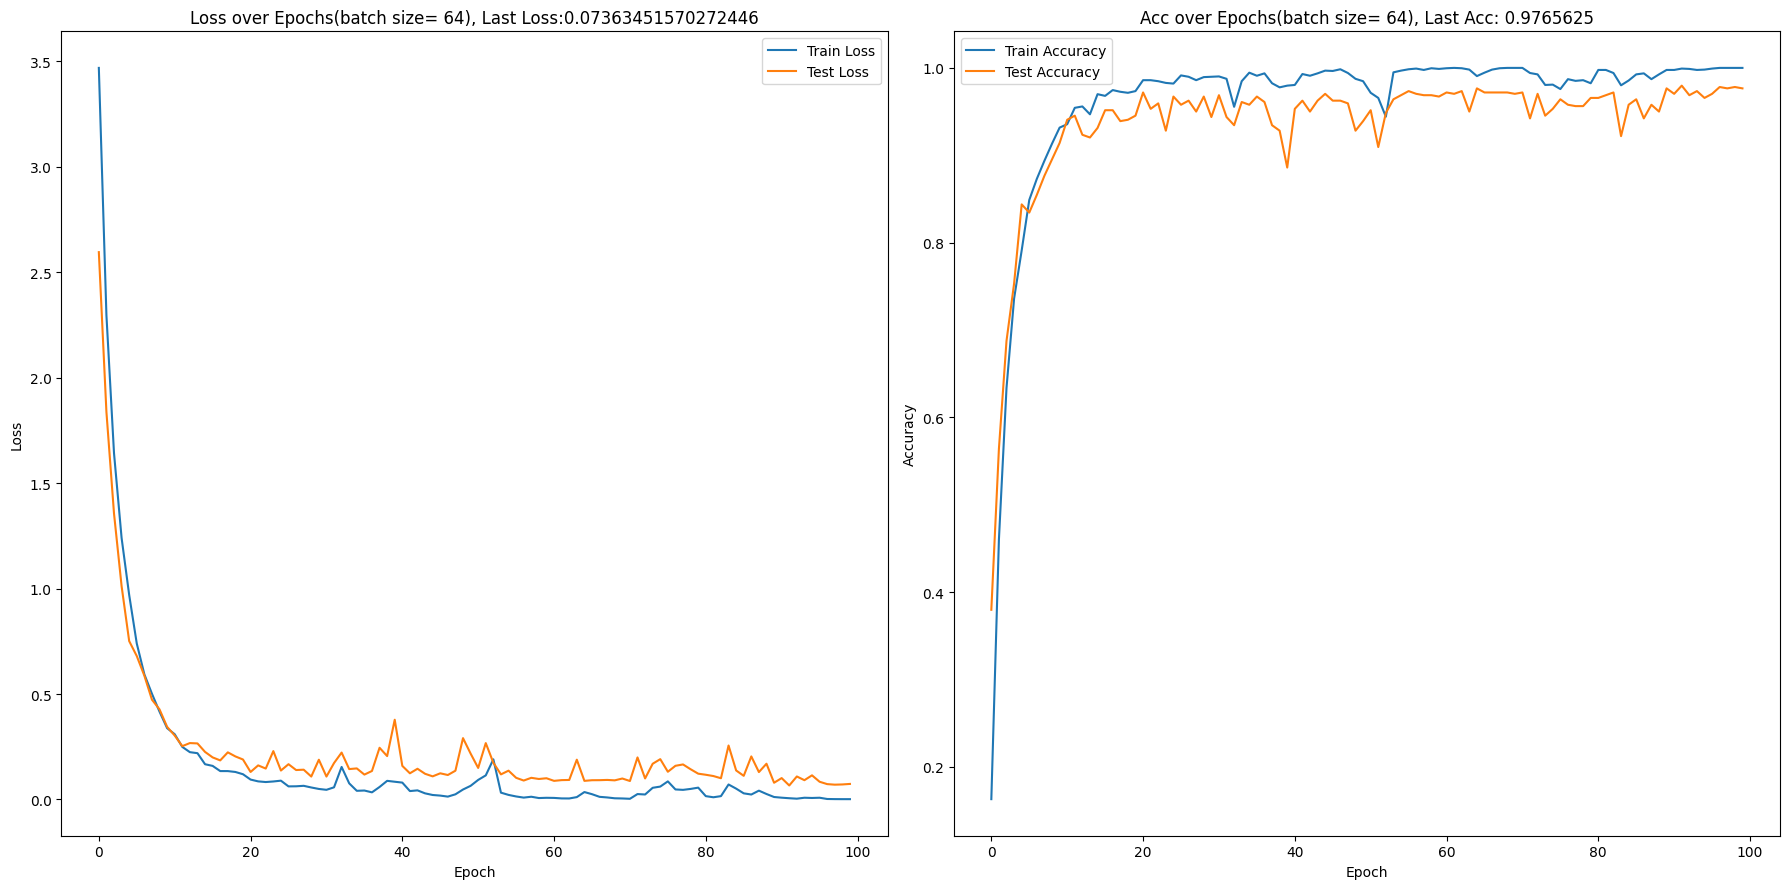

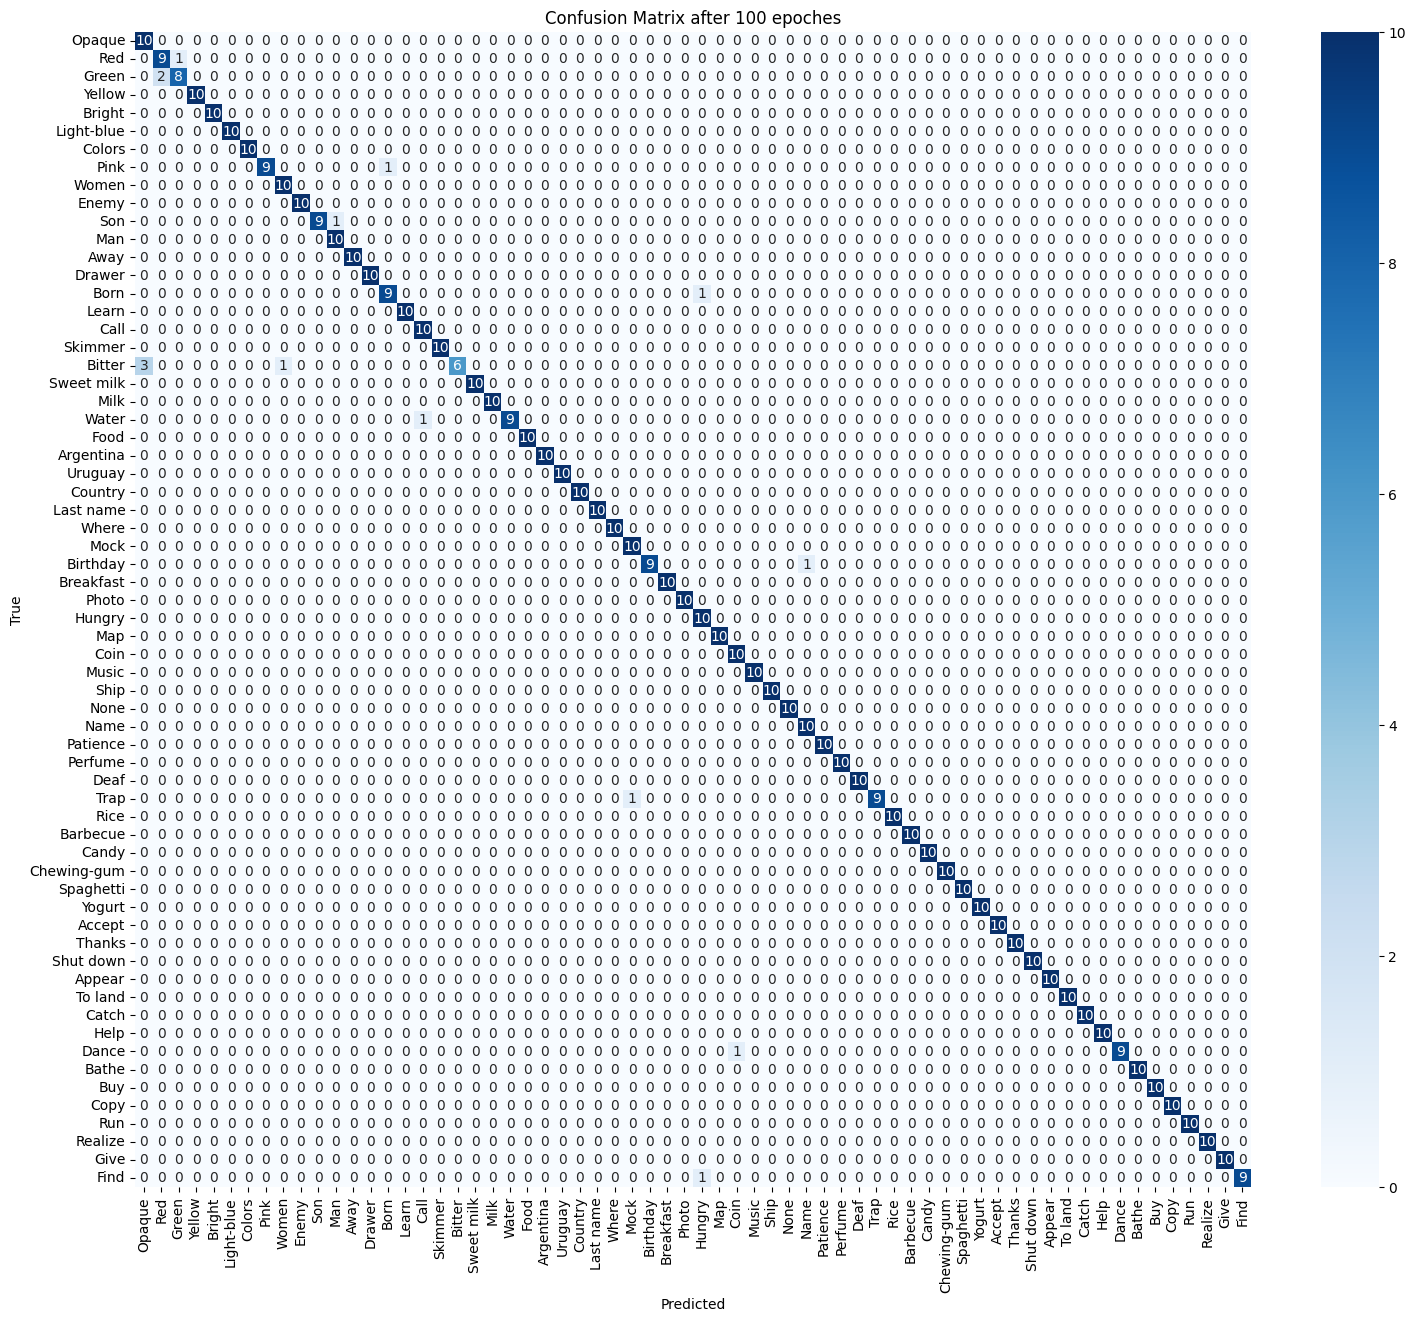

In [19]:
train.configure(detections= filtered_detections,                         # detections
                labels= lsa64_labels['30frames'],                        # labels
                class_names= prepare_datasets.lsa64class_names,          # classes
                test_size= 0.2,                                          # test split size
                batch_size= 64,                                          # batch size
                num_epochs= 100,                                         # number of epochs
                model= model,                                            # model
                lr= 0.0001,                                              # learning rate
                device= device,                                          # processing device
                quick_save= True,                                        # save the plots in the current directory?
                results_name= '30fps_b_64_nl_2_nh_6_dff_2048',           # resutls name
                dataset_name= 'LSA64')                                   # to determine under which dataset folder the tensorboard file is saved.

# Using Saliency

1. prepare the data

In [ ]:
# converting detections and labels to the right format again
X, y= preprocess_utils.convert(detections= filtered_detections,
                               labels= lsa64_labels['30frames'],
                               class_names= prepare_datasets.lsa64class_names) 
# making a datast object
dataset = train.CustomDataset(X, y)
# choosing one sample
video_detection_sample, label_sample = dataset[0]

***Note:***: Although the dataset is **shuffled during training**, the dataset object created above is **ordered by label**. 
The dataset object is structured as follows:
- `video1, label1`, `video2, label1`, `video3, label1`, ..., `videon, label1`
- `video1, label2`, `video2, label2`, `video3, label2`, ..., `videon, label2`
- And so on for each label...

2. define `Saliency` object

In [28]:
sailency= Saliency(forward_func= model)

Calculating attribution scores for a video sample

In [ ]:
lm_attributions= analyse_layer.landmark_attributions(model= model,
                                                     captum_method= sailency,
                                                     video_detection= video_detection_sample,
                                                     label= label_sample,
                                                     device= device)

analyse_layer.plot_atts_heatmap(attributions= lm_attributions, save_path= 'transformer_trained_label_0.png', show_landmark_names= True)

***Calculating average attribution score for the entire dataset***

In [ ]:
lm_atts_dataset= analyse_layer.landmark_attributions_for_dataset(model= model,
                                                                 captum_method= sailency,
                                                                 dataset= dataset,
                                                                 device= device)

analyse_layer.plot_atts_heatmap(attributions= lm_atts_dataset, save_path= 'transformer_trained_over_dataset.png', show_landmark_names= True)

***Calculating attribution scores across calsses of the dataset***

1. Define a dictionary to store all indexes of samples that belong to the same label.
The dictionary has the following structure:

- The labels have been converted to numbers. Each **label** is a key, and the corresponding value is a list of indices representing the videos for that label. The length of the list may vary, as different labels can have a different number of videos.

Example:

```python
{
    "0": [0, 1, 2, ..., n],
    "1": [0, 1, 2, 3, ..., m],
    ...
}

In [ ]:
from torch.utils.data import Subset

word_positions = defaultdict(list)
for i, (data, label) in enumerate(dataset):
    word_positions[label.item()].append(i)

2. For all videos under the same label, we calculate the average attribution scores and plot it.

In [ ]:
for i in range(len(prepare_datasets.lsa64class_names)):
    subset_dataset = Subset(dataset, word_positions[i])  # Correct the variable name (i not I)
    lm_atts_word = analyse_layer.landmark_attributions_for_dataset(model= model,
                                                                   captum_method= new_sailency,
                                                                   dataset= subset_dataset,
                                                                   device= device)
    
    analyse_layer.plot_atts_heatmap(attributions= lm_atts_word, save_path= f'{i+1}.png', show_landmark_names= True)

***comparing saliency maps with untrained model***

1. define same model that was trained again

In [312]:
new_model= models.ParamTransformer(class_names= prepare_datasets.lsa64class_names,
                                   seq_len= 30,
                                   d_model= 258,
                                   nhead= 6,
                                   d_ff= 2048,
                                   num_layers= 2,
                                   dropout=0.1)

2. define a new `Saliency` object

In [217]:
new_sailency= Saliency(forward_func= model)

2. saliency maps for a sample video

In [ ]:
lm_attributions= analyse_layer.landmark_attributions(model= new_model,
                                                     captum_method= new_sailency,
                                                     video_detection= video_detection_sample,
                                                     label= label_sample,
                                                     device= device)

analyse_layer.plot_atts_heatmap(attributions= lm_attributions, save_path= 'transformer_untrained_label_0.png', show_landmark_names= True, vmin= 0.0, vmax= 0.1)

***Calculating average attribution score for the entire dataset***

In [ ]:

lm_atts_dataset= analyse_layer.landmark_attributions_for_dataset(model= model,
                                                                 captum_method= new_sailency,
                                                                 dataset= ConcatDataset([train_dataset, test_dataset]),
                                                                 device= device)

analyse_layer.plot_atts_heatmap(attributions= lm_atts_dataset, save_path= 'transformer_untrained_over_dataset.png', show_landmark_names= True, vmin= 0, vmax= 0.14)

# Plotting Saliency attribution scores on a video

1. define a video path

In [29]:
video_path= "C:/Users/sadeg/OneDrive/Desktop/Thesis/python_codes/datasets/lsa64_raw/all/001_002_001.mp4"

2. plot the attribution scores on the video

In [290]:
analyse_layer.plot_attributions_on_video(video_path= video_path,
                                         model= model,
                                         captum_method= sailency,
                                         class_names= prepare_datasets.lsa64class_names,
                                         device= device, 
                                         frame_numbers= 30)

Calculating landmark attributions for the sign language video Opaque


# K-fold cross validation:

1. define model configuration

In [134]:
model_args = {'class_names': prepare_datasets.lsa64class_names,
              'seq_len': 30,
              'd_model': 258,              
              'nhead': 6, 
              'd_ff': 2048,                
              'num_layers': 1, 
              'dropout': 0.1}

2. perform cross validation

In [ ]:
train.configure_Kfold(detections= filtered_detections,
                      labels= lsa64_labels['60frames'],
                      class_names= prepare_datasets.lsa64class_names,
                      n_splits= 5,
                      batch_size= 64,
                      num_epochs= 100,
                      model_class= models.PETransformer,
                      model_args= model_args,
                      lr= 0.0001,
                      device= device,
                      quick_save= False)

***Note:*** Below is a cell that executes **K-Fold Cross Validation**. It was used to modify parameters and performe the augmentation step more easily without having to change the `configure_kfold` function and save the `train.py` file every time.

In [ ]:
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import KFold

# Paths
experiment_dir = "C:/Users/sadeg/OneDrive/Desktop/Thesis/python_codes/SignLanguageProject/experiment_results"
dataset_name = "LSA64"
results_name = "exampleResult"

# Parameters
kf = KFold(n_splits=5, shuffle=True)   # kfold object
batch_size = 64                        # batch number
num_epochs = 100                       # number of epochs

# Store overall results for K-Fold
k_fold_accuracies = []
k_fold_losses = []

# Iterate based on number of folds
for fold, (train_index, test_index) in enumerate(kf.split(lsa64_detections['30frames'])):
    print(f"\n=== Processing Fold {fold + 1} ===")

    # Splitting the dataset into training and testing for this fold
    x_train, x_test = lsa64_detections['30frames'][train_index], lsa64_detections['30frames'][test_index]
    y_train, y_test = np.array(lsa64_labels['30frames'])[train_index].tolist(), np.array(lsa64_labels['30frames'])[test_index].tolist()
    #print(x_train.shape, len(y_train), x_test.shape, len(y_test))

    # Augmentation with linear interpolation and adding Gaussian noise
    x_train, y_train = preprocess_utils.interpolate_dataset(x_train, y_train, alpha=0.5, noise_level= 0.01) 
    # print(x_train.shape, len(y_train), x_test.shape, len(y_test))

    # Eliminating the head landmarks
    pose = np.arange(0, 132)
    lh_and_rh = np.arange(1536, 1662)
    indices_to_keep = np.concatenate((pose, lh_and_rh))
    x_train = x_train[:, :, indices_to_keep]  # Filter out head landmarks from x_train 
    x_test = x_test[:, :, indices_to_keep]    # Filter out head landmarks from x_test
    #print(x_train.shape, len(y_train), x_test.shape, len(y_test))

    # Convert x_train, y_train and x_test, y_test to the correct format for training 
    x_train, y_train = preprocess_utils.convert(x_train, y_train, prepare_datasets.lsa64class_names)
    x_test, y_test = preprocess_utils.convert(x_test, y_test, prepare_datasets.lsa64class_names)
    # print(type(x_train), type(y_train), type(x_test), type(y_test))  # check the types

    # Create datasets and dataloaders for training and testing
    train_dataset = train.CustomDataset(x_train, y_train)
    test_dataset = train.CustomDataset(x_test, y_test)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=0, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=0, shuffle=False)

    # Initialize the model for this fold
    model = models.PETransformer(class_names=prepare_datasets.lsa64class_names,
                                 seq_len=30,
                                 d_model=258,
                                 nhead=6,
                                 d_ff=2048,
                                 num_layers=4,
                                 dropout= 0.1)
    # send model to the device
    model = model.to(device)

    # Define loss function and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # Directory for saving results specific to this fold
    fold_dir = f'{experiment_dir}/{dataset_name}/{model.model_type}/runs/{results_name}/fold_{fold + 1}'

    # Lists to store the accuracy and loss for each epoch in this fold
    epoch_accuracies = []
    epoch_losses = []

    # Train the model for this fold
    train_l, test_l, train_a, test_a, y_trues, y_preds = train_utils.train_model(num_epochs,
                                                                                 model,
                                                                                 train_loader,
                                                                                 test_loader,
                                                                                 optimizer,
                                                                                 loss_fn,
                                                                                 device)
    # Store losses and accuracies for each epoch in this fold
    epoch_accuracies.extend(test_a)
    epoch_losses.extend(test_l)
    
    # plot results for this fold
    plot_utils.plot_loss_accuracy(train_l, test_l, train_a, test_a, batch_size, f'loss_acc_fold_{fold + 1}.png')
    #plot_utils.plot_confusion_matrix(y_trues, y_preds, prepare_datasets.autslclass_names, num_epochs, f'confmat_fold_{fold + 1}.png')
    #plot_utils.draw_in_tensorboard(train_l, test_l, train_a, test_a, fold_dir)
    
    # Store final accuracy and loss for this fold
    final_accuracy = test_a[-1]                        # the final epoch's test accuracy
    final_loss = test_l[-1]                            # the final epoch's test loss
    print(f"\n=== Fold {fold + 1} Results ===")
    print(f"Fold {fold + 1} Final Accuracy: {final_accuracy:.4f}")
    print(f"Fold {fold + 1} Final Loss: {final_loss:.4f}")
    
    k_fold_accuracies.append(final_accuracy)           # store the final test accuracy
    k_fold_losses.append(final_loss)                   # store the final test accuracy

    print(f"Completed Fold {fold + 1}")


# Calculate K-Fold metrics
min_accuracy = np.min(k_fold_accuracies)              # minimum accuracy of the experiment
max_accuracy = np.max(k_fold_accuracies)              # maximum accuracy of the experiment
mean_accuracy = np.mean(k_fold_accuracies)            # average accuracy of the experiment
std_accuracy = np.std(k_fold_accuracies)              # standard deviation of final test accuracies of the experimen
mean_loss= np.mean(k_fold_losses)                     #  average loss of the experiment

# Print final K-Fold summary
print("\n=== K-Fold Summary ===")
print(f"Min Accuracy: {min_accuracy:.4f}")
print(f"Max Accuracy: {max_accuracy:.4f}")
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Standard Deviation (Accuracy): {std_accuracy:.4f}\n")
print(f"mean loss: {mean_loss:.4f}")